In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import tensorflow as tf
import numpy as np
# tf.device('/gpu:1')

from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt

from Field import * # Finite Field class

seed = 1337
tf.set_random_seed(seed)
np.random.seed(seed)

In [2]:
P = 3  # Galois Field: GF{2^P}
num_iterations = 10   # number of cs-bp iterations
BATCH_SIZE = 100      # predefined batch size
NOISE_VAR = 0.01
SPARSITY = 0.068      # predefined the sparsity of source signal

In [3]:
N = 100   # the number of columns of parity-check matrix
DV = 2   #  column weights of parity-check matrix
DC = 4   # row weights of 

# Generate the parity-check matrix by Gallager's approach
# Matrix satisfies: M * DC = N * DV
from gallager import parity_check_matrix
# ParityCheckMatrix = parity_check_matrix(N,DV,DC,seed)

In [4]:
# load list of predefined matrices
# dims: 5 * 10
# ParityCheckMatrix = np.array([[1, 0, 1, 0, 1, 1, 1, 0, 1, 0],[0, 1, 1, 1, 0, 1, 0, 1, 1, 0],[1, 0, 1, 1, 0, 0, 1, 0, 1, 1],[0, 1, 0, 1, 1, 0, 1, 1, 0, 1],[1, 1, 0, 0, 1, 1, 0, 1, 0, 1]])
ParityCheckMatrices = [[[1,0,1,1,1,0,0],[0,1,0,1,1,1,0],[0,0,1,0,1,1,1]],[[1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,1,1,0,0,1,1]],[[1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1]],[[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],[0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0],[1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],[1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],[1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]]
ParityCheck_id = 3   # decide which parity check matrix should be used (0-2: BCH; 3: LDPC)
ParityCheckMatrix = np.array(ParityCheckMatrices[ParityCheck_id])   # load parity-check matrix

In [5]:
n = ParityCheckMatrix.shape[1]   # define number of information symbols n 
m = ParityCheckMatrix.shape[0]   # define number of measruemennts symbols m
coderate = (n-m)/n   # coderate as fraction of information bits per CWs
# print parity-check matrix
# print(ParityCheckMatrix)
print('n:{}, m:{}, coderate:{}'.format(n,m,coderate))

n:100, m:50, coderate:0.5


In [6]:
H = tf.Variable(ParityCheckMatrix, trainable=False, dtype=tf.float32)
batch_size = tf.placeholder_with_default(BATCH_SIZE, shape=())
noise_var = tf.placeholder_with_default(NOISE_VAR , shape=())

In [7]:
# Generate Wash-Hadamard transform matrix for FFT accelerating
from scipy.linalg import hadamard
def wash_hadamard_transform(prob, p,dims,inverse = False):
    HADAMARD_MATRIX = hadamard(1<<p)
    # print(HADAMARD_MATRIX )
    hadarmard_mat = tf.constant(HADAMARD_MATRIX,dtype =tf.float32)
#     hadarmard_mat = tf.expand_dims(tf.expand_dims(hadarmard_mat ,axis = 0),axis = 0)
    hadarmard_prob = tf.expand_dims(prob,axis = dims) * hadarmard_mat
    transformed_prob = tf.reduce_sum(hadarmard_prob, axis = dims-1)
    # wash-hadamard inverse transform
    if inverse:  
        transformed_prob = transformed_prob / (1 << p)
    return transformed_prob

In [8]:
# Generate the source signal for CS
import random
def generate_source_signal(n,p,sparsity):
    x = [0] * n
    K = int( n * sparsity)
    q = 1 << p
    for i in range(K):
        x[i] = random.randint(1,q-1)
    random.shuffle(x)
    print("x: ", x)
    return x

In [9]:
# Conduct compressed sensing to source signal x and get measurement signal y
def compressed_sensing_encoder(x,p,m,n,cs_matrix):
    from Field import FField 
    field_p = FField(p)
    y = []
    for i in range(m):   # rows
        value = 0
        for j in range(n):
            temp_value = field_p.Multiply(x[j],cs_matrix[i][j])
            value = field_p.Add(value, temp_value)
        y.append(value)
    return y

In [10]:
# Some util functions
def dec2bin(num,p):
    l = []
    while p > 0:
        num, remainder = divmod(num, 2)
        l.append(remainder)
        p = p - 1 
#     l = l.reverse()
    return l[::-1]


def bin2dec(l,p):
    value =0
    while p>0:
        value = value + l[p-1]*2**(p-1)
        p = p-1
    return value
    
def ebnodb2noisevar(ebno_db, coderate):
    ebno = 10**(ebno_db/10)
    noise_var = 1/(2*coderate*ebno)  
    return noise_var

def construct_transition_matrix(p):
    Q = 1 << p  # q = 2^p
    mat = [ dec2bin(q,p) for q in range(Q)]  # q * p
    mat = tf.transpose(tf.constant(mat,dtype = tf.float32), perm = [1,0])
    mat = 1- 2 * mat # p * q
    return mat 

# Normalize the probability
def normalization(prob,dims):
#     prob = tf.where(tf.equal(prob,0),tf.ones_like(prob)*1e-15, prob)
    H_unconnected = tf.cast(tf.equal(prob,0),dtype = tf.float32)
    sum_prob = tf.reduce_sum(prob,axis = dims-1,keepdims = True)
    norm_prob = prob / (sum_prob + H_unconnected)
    return norm_prob

In [11]:
# Transit the p-nary sequence y to awgn channel
def awgn_channel(y,p):
    binary_y = tf.constant([dec2bin(symb,p) for symb in y], shape = [m,p],dtype=tf.float32)
    bpsk_y = 2 * binary_y - 1
    noise = tf.random_normal(shape = [batch_size, m, p], stddev = tf.sqrt(noise_var))
    channel_outputs = bpsk_y + noise
    return channel_outputs

# Compute the channel transition probability given channel outputs
def compute_awgn_channel_transition_probability(channel_outputs, p):
    
    transition_mat = construct_transition_matrix(p) # p * q
    transition_values =  tf.expand_dims(2 * channel_outputs / noise_var, axis = 3) # batchsize * m * p * 1 
    transition_prob_mat = 1 / (1 + tf.exp(transition_values * transition_mat)) # batchsize * m * p * q
    transition_prob = tf.reduce_prod(transition_prob_mat,axis = 2) # batchsize * m * q
    
    transition_prob = normalization(transition_prob,dims = 3)# batchsize * m * q
    transition_prob = tf.clip_by_value(transition_prob, clip_value_min = 1e-10,clip_value_max = 9.999999e-01)
    
    return transition_prob_mat, transition_prob

In [12]:
# Initialize the v2c information by probability of sources
def init_vc(n,sparsity,p,uniform = True):
    q = 1<<p
    prob_seq = []
    for i in range(q):
        if i==0:
            prob_seq.append(1-sparsity)
        else:
            prob_seq.append(sparsity * 1/(q-1))

    pr0 = [prob_seq for i in range(n)]
    
    # pr0 dims: n * q
    pr0 = tf.constant(pr0,dtype = tf.float32) 
    
    # vc0 dims: n * m * q
    vc0 = tf.transpose(tf.expand_dims(H,axis=2) * tf.expand_dims(pr0,axis=0), perm=[1,0,2])
    
    return pr0,vc0

In [13]:
# Update C2V information
def check_2_var(vc,vc0,channel_prob, H, p, init = False):
    # Applying Wash-Hadamard transform to channel_prob
    wht_channel_prob = wash_hadamard_transform(channel_prob,p,3) # batchsize * m * q 
    
    # Update c2v information
    if init:
        wht_vc0 = wash_hadamard_transform(vc0,p,3) # n * m * q
        wht_vc = tf.transpose(wht_vc0,perm = [1,0,2]) # dims: m * n * q
        
        # dims: m * n * q
        H_unconnected = tf.cast(tf.equal(wht_vc,0),dtype = tf.float32)
        
        wht_vc_prod = tf.reduce_prod(wht_vc + H_unconnected, axis = 1, keepdims = True)
        wht_vc_prod = tf.where(tf.equal(wht_vc_prod,0), tf.ones_like(wht_vc_prod) * 1e-12, wht_vc_prod)
        wht_cv = wht_vc_prod / (wht_vc + H_unconnected) * tf.expand_dims(H,axis = 2)# dims: m * n * q
        
        # dims: batchsize * m * n * q
        wht_cv = tf.expand_dims(wht_cv,axis = 0) * tf.expand_dims(wht_channel_prob, axis = 2 ) # dims: batchsize * m * n * q
    
        cv = wash_hadamard_transform(wht_cv,p,dims=4, inverse = True)
        cv = normalization(cv, dims=4) # batchsize * m * n * q
        return cv
    
    else:
        # Applying WHT transform to vc
        wht_vc = wash_hadamard_transform(vc,p,4) # dims: batchsize * n * m * q
        wht_vc = tf.transpose(wht_vc,perm = [0,2,1,3]) 
        
        # dims: batchsize * m * n * q  
        H_unconnected = tf.cast(tf.equal(wht_vc,0),dtype = tf.float32)
        H_connected = tf.cast(tf.equal(H_unconnected,0),tf.float32)
        
        wht_vc_prod = tf.reduce_prod(wht_vc + H_unconnected, axis = 2, keepdims = True)
        wht_vc_prod = tf.where(tf.equal(wht_vc_prod,0), tf.ones_like(wht_vc_prod) * 1e-12, wht_vc_prod)
        
        wht_cv = wht_vc_prod / (wht_vc + H_unconnected) * H_connected 
        wht_cv = wht_cv * tf.expand_dims(wht_channel_prob, axis = 2 ) 
        
        cv = wash_hadamard_transform(wht_cv, p, dims = 4, inverse = True)
        cv = normalization(cv, dims = 4) # batchsize * m * n * q 
        return cv

In [14]:
# Update V2C information
def var_2_check(cv, vc0, pr0, H, p, final = False):
    H_unconnected = tf.cast(tf.equal(cv,0),dtype = tf.float32)
    H_connected = tf.cast(tf.equal(H_unconnected,0),tf.float32)
    
    # Update v2c information
    # dims : batchsize * m * n * q 
    cv_prod = tf.reduce_prod(cv + H_unconnected , axis = 1, keepdims = True)
    cv_prod = tf.where(tf.equal(cv_prod,0), tf.ones_like(cv_prod) * 1e-12, cv_prod)
    vc = tf.transpose( (cv_prod / (cv + H_unconnected)) * H_connected, perm=[0,2,1,3])
    vc = vc * tf.expand_dims(vc0,axis=0) # dims: batchsize * n * m * q 
    vc = normalization(vc, dims = 4) 
    
    # Decoding decision
    # dims : batchsize * n * q 
    cv_prod_ = tf.reduce_prod(cv + H_unconnected , axis = 1)
    cv_prod_ = tf.where(tf.equal(cv_prod_,0), tf.ones_like(cv_prod_) * 1e-12, cv_prod_)
    
    pr = cv_prod_ * tf.expand_dims(pr0,axis = 0)
    pr = normalization(pr,dims = 3) 
    
    if final:
        return pr, pr
    else:
        return vc, pr

In [15]:
## --------------------------------------------------------------------------------
## -------------------------------- Encoding --------------------------------------
x_list = generate_source_signal(n,P,SPARSITY)
x = tf.constant(x_list,dtype=tf.float32)

### y = H * x (over Finite field)
y = compressed_sensing_encoder(x_list,P,m,n,ParityCheckMatrix)
print('y: ',y)

recieve_y = awgn_channel(y,P)
transmat,channel_prob = compute_awgn_channel_transition_probability(recieve_y,P)

pr0, vc0 = init_vc(n,SPARSITY,P) # vc0 dims : n * m * q
vc = tf.zeros(shape = [batch_size, n, m, int(1<<P)])

x:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 5]
y:  [0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 0, 1, 0, 7, 0, 0, 7, 7, 2, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 7, 0, 4, 0]


In [16]:
# -----------------------------------------------------------------------------------
## -------------------------------- Decoding ----------------------------------------
W_vc=tf.placeholder_with_default(tf.ones(shape=[1,n,m,(1<<P)]),shape=[1,n,m,(1<<P)]) 
W_cv=tf.placeholder_with_default(tf.ones(shape=[1,m,n,(1<<P)]),shape=[1,m,n,(1<<P)])
for i in range(num_iterations):
    is_final = (i==num_iterations-1)
    is_init = (i==0)
    cv = check_2_var(W_vc*vc, vc0,channel_prob, H, P, is_init)  # cv dims:batchsize * m * n * q 
    vc, pr = var_2_check(W_cv*cv, vc0, pr0, H, P, is_final)     # vc dims:batchsize * n * m * q 
    #cv = check_2_var(vc, vc0,channel_prob, H, P, is_init)  # cv dims:batchsize * m * n * q 
    #vc, pr = var_2_check(cv, vc0, pr0, H, P, is_final)     # vc dims:batchsize * n * m * q 
# pr dims: batchsize * n * q
x_hat = tf.cast(tf.argmax(pr, axis = 2), dtype = tf.float32) # batchsize * n
fer = tf.reduce_mean(tf.cast(tf.not_equal(x,x_hat),dtype = tf.float32))


In [17]:
# sess = tf.InteractiveSession()
# tf.global_variables_initializer().run()
# xh, fer_,pr_ = sess.run([x_hat,fer,pr], feed_dict={
#             batch_size: 10,
#             noise_var:ebnodb2noisevar(1, coderate)
#         })

In [18]:
# ----------------------------------------------------------------------------------
# ------------------------------ Run -----------------------------------------------
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

samples = 100
epochs = 10
ebnos_db = np.linspace(1,6,6)
fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_no_training[i] += sess.run(fer, feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_no_training /= epochs

In [19]:
fers_no_training

array([0.02616, 0.02028, 0.01456, 0.01139, 0.01002, 0.01166])

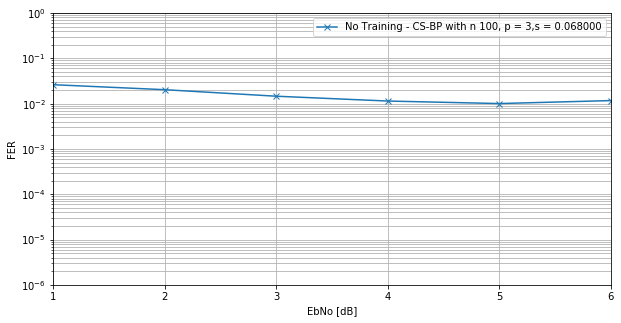

In [20]:
plt.figure(figsize=(10, 5))
plt.semilogy(ebnos_db, fers_no_training, '-x')
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('FER');
plt.ylim([1e-6, 1e-0]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['No Training - CS-BP with n %d, p = %d,s = %f' % (n,P,SPARSITY)]);

# Optimizer

In [48]:
import random

In [49]:
def unfolded_csbp(w_vc,w_cv,epochs=10,samples=100):

    ebnos_db = np.linspace(1,6,6)
    fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

    for j in range(epochs):
        for i in range(ebnos_db.shape[0]):
            ebno_db = ebnos_db[i]
            fers_no_training[i] += sess.run(fer, feed_dict={
                W_vc:w_vc,
                W_cv:w_cv,
                batch_size: samples,
                noise_var: ebnodb2noisevar(ebno_db, coderate)
            })
    fers_no_training /= epochs
    fers_av=np.mean(fers_no_training)
    return fers_av;

In [50]:
def fitnessfunc(W_vc_population,
                W_cv_population,
                sol_per_pop=8,
                samples = 100,
                epochs = 10):
    fitness=np.zeros([sol_per_pop])
    for i in range(sol_per_pop):
        fitness[i]=unfolded_csbp(W_vc_population[i],W_cv_population[i]);
    return fitness;

In [51]:
def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return np.array(pop_weights_vector)

In [52]:
def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [53]:
def select_mating_pool(pop_w_vc_vector, pop_w_cv_vector,fitness, num_of_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents_of_w_vc=[];parents_of_w_cv=[];
    for parent_num in range(num_of_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents_of_w_vc.append(pop_w_vc_vector[min_fitness_idx, :]) # dims:[num_of_parents,(m*n*8)]
        parents_of_w_cv.append(pop_w_cv_vector[min_fitness_idx, :]) # dims:[num_of_parents,(m*n*8)]
        fitness[min_fitness_idx] = -99999999999
    return np.array(parents_of_w_vc),np.array(parents_of_w_cv)


In [54]:
def crossover(parents_of_w_vc,parents_of_w_cv, num_of_offsprings,num_of_parents):
    offspring_of_w_vc=[];offspring_of_w_cv=[]
    offs_w_vc=np.empty([parents_of_w_vc.shape[1]])
    offs_w_cv=np.empty([parents_of_w_cv.shape[1]])
    crossover_point = np.uint8(parents_of_w_vc.shape[1]/2);
    for k in range(num_of_offsprings):
        # Index of the first parent to mate.
        parent1_idx = k%num_of_parents
        # Index of the second parent to mate.
        parent2_idx = (k+1)%num_of_parents
        # The new offspring will have its first half of its genes taken from the first parent.
        offs_w_vc[0:crossover_point] = parents_of_w_vc[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offs_w_vc[crossover_point:] = parents_of_w_vc[parent2_idx, crossover_point:]
        offs_w_cv[0:crossover_point] = parents_of_w_cv[parent1_idx, 0:crossover_point]
        offs_w_cv[crossover_point:] = parents_of_w_cv[parent2_idx, crossover_point:]
        offspring_of_w_vc.append(offs_w_vc);
        offspring_of_w_cv.append(offs_w_cv);
    return np.array(offspring_of_w_vc), np.array(offspring_of_w_cv ) 

In [55]:
def mutation(offspring_of_w_vc, offspring_of_w_cv, mutation_percent):#,mutation_degree):
    num_mutations = np.uint8((mutation_percent*offspring_of_w_cv.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_of_w_cv.shape[1]), num_mutations))
    for idx in range(offspring_of_w_vc.shape[0]):
        #random_value = numpy.random.uniform(-1.0*mutation_degree, 1.0*mutation_degree, 1)
        offspring_of_w_vc[idx,mutation_indices] = np.random.uniform(0.5, 2, num_mutations);
        offspring_of_w_cv[idx,mutation_indices] = np.random.uniform(0.5, 2, num_mutations);
    return offspring_of_w_vc, offspring_of_w_cv;
    

In [56]:
sol_per_pop=8;
num_generations=2000;
num_of_parents=4;
mutation_percent=0.01
num_of_offsprings=sol_per_pop-num_of_parents
accuracies = np.empty(shape=(num_generations))

In [57]:
initial_pop_w_cv = [] #dims:[sol_per_pop, 1, m, n, q]
initial_pop_w_vc = [] #dims:[sol_per_pop, 1, n, m, q]
for curr_sol in np.arange(0, sol_per_pop):
    initial_pop_w_vc.append(np.random.uniform(low=0.5, high=2.0, size=([1,n,m,(1<<P)])))
    initial_pop_w_cv.append(np.random.uniform(low=0.5, high=2.0, size=([1,m,n,(1<<P)])))
    
pop_w_cv_mat = np.array(initial_pop_w_cv) #dims:[sol_per_pop,1,m,n,q]
pop_w_vc_mat = np.array(initial_pop_w_vc) # dims:[sol_per_pop,1,n,m,q]

pop_w_cv_vector = mat_to_vector(pop_w_cv_mat) #dims:[sol_per_pop,(m*n*8)]
pop_w_vc_vector = mat_to_vector(pop_w_vc_mat) #dims:[sol_per_pop,(m*n*8)]

In [58]:
for generation in range(num_generations):
    pop_w_cv_mat = vector_to_mat(pop_w_cv_vector,pop_w_cv_mat) 
    pop_w_vc_mat = vector_to_mat(pop_w_vc_vector,pop_w_vc_mat) 
    fitness=fitnessfunc(pop_w_vc_mat,pop_w_cv_mat)
    accuracies[generation] = fitness[0]
    print("Generation{}:Fitness{}".format(generation,fitness))
    # Selecting the best parents in the population for mating.
    parents_of_w_vc,parents_of_w_cv=select_mating_pool(pop_w_vc_vector, pop_w_cv_vector,fitness.copy(), num_of_parents)
    # Generating next generation using crossover.
    offspring_of_w_vc, offspring_of_w_cv=crossover(parents_of_w_vc,parents_of_w_cv, num_of_offsprings,num_of_parents)
    # Adding some variations to the offsrping using mutation.
    offspring_of_w_vc, offspring_of_w_cv=mutation(offspring_of_w_vc, offspring_of_w_cv, mutation_percent)
    #update
    pop_w_cv_vector[0:num_of_parents]=parents_of_w_cv;
    pop_w_cv_vector[num_of_offsprings:]=offspring_of_w_cv
    pop_w_vc_vector[0:num_of_parents]=parents_of_w_vc;
    pop_w_vc_vector[num_of_offsprings:]=offspring_of_w_vc
    

Generation0:Fitness[0.00969833 0.00872167 0.01180333 0.01213167 0.01040667 0.01399
 0.011005   0.01612667]
Generation1:Fitness[0.00876167 0.00873    0.008665   0.00874833 0.00928167 0.00902833
 0.00950667 0.00918167]
Generation2:Fitness[0.00875167 0.008755   0.00876833 0.00882167 0.00904333 0.00884833
 0.00880833 0.008955  ]
Generation3:Fitness[0.00886833 0.00902    0.0084     0.00885    0.008765   0.00873833
 0.008745   0.00881167]
Generation4:Fitness[0.00867    0.00869167 0.00865833 0.00861    0.00873833 0.00887167
 0.00877333 0.00875167]
Generation5:Fitness[0.00886667 0.00874333 0.00870167 0.00869667 0.00884167 0.00881
 0.00881167 0.00860167]
Generation6:Fitness[0.00892833 0.00905833 0.00891667 0.00876833 0.00876833 0.00865333
 0.00891667 0.00864333]
Generation7:Fitness[0.009035   0.00858167 0.00885    0.00894333 0.008995   0.00891167
 0.00903167 0.00907833]
Generation8:Fitness[0.00881833 0.00871833 0.00878333 0.00853167 0.00860833 0.00865667
 0.00862833 0.008655  ]
Generation9:Fitn

Generation75:Fitness[0.00815167 0.00846667 0.00828    0.00817833 0.00841833 0.008195
 0.00821333 0.00824667]
Generation76:Fitness[0.008345   0.00834833 0.00810667 0.00800167 0.00831833 0.008035
 0.00839167 0.00819   ]
Generation77:Fitness[0.008255   0.00815    0.008595   0.00807    0.008385   0.00816167
 0.008205   0.00821   ]
Generation78:Fitness[0.00823667 0.00844167 0.008315   0.00819667 0.00834667 0.00827
 0.00814667 0.00808167]
Generation79:Fitness[0.00829167 0.007945   0.00824167 0.00825167 0.00820667 0.00813667
 0.00826    0.00813   ]
Generation80:Fitness[0.00838333 0.00836833 0.00818833 0.00814167 0.00848167 0.00818167
 0.00826    0.00817667]
Generation81:Fitness[0.00837167 0.008255   0.007975   0.00820167 0.008085   0.008315
 0.00796833 0.00816833]
Generation82:Fitness[0.00815167 0.00834833 0.00809167 0.00833    0.00816667 0.00800167
 0.00824833 0.008365  ]
Generation83:Fitness[0.00819667 0.00824833 0.00813833 0.008085   0.00834333 0.00813833
 0.008065   0.00828   ]
Generation

Generation149:Fitness[0.00726    0.007175   0.00697333 0.00703667 0.007175   0.00708833
 0.00729667 0.00707   ]
Generation150:Fitness[0.00711167 0.00727167 0.00711667 0.006855   0.00718    0.00693667
 0.00725167 0.00704667]
Generation151:Fitness[0.00702    0.00718    0.00697167 0.00716    0.00716167 0.00711667
 0.00697333 0.00724167]
Generation152:Fitness[0.00706333 0.00681    0.00722333 0.00707333 0.00707333 0.007145
 0.007105   0.007105  ]
Generation153:Fitness[0.00733    0.00723    0.00714833 0.00709667 0.00717667 0.00709
 0.00727833 0.007335  ]
Generation154:Fitness[0.00700667 0.00695    0.007225   0.006855   0.0072     0.00698667
 0.00704167 0.00704833]
Generation155:Fitness[0.00716    0.00698833 0.007115   0.00691667 0.00715    0.00722333
 0.00733333 0.00694833]
Generation156:Fitness[0.00724833 0.00695667 0.00692    0.00721333 0.00714167 0.00727167
 0.00726333 0.00733833]
Generation157:Fitness[0.00721333 0.00736167 0.00707333 0.00727    0.00705833 0.00717333
 0.00714    0.007075 

Generation223:Fitness[0.00656833 0.0062     0.00648    0.006495   0.00645333 0.00636
 0.006335   0.006265  ]
Generation224:Fitness[0.00610167 0.00637833 0.006235   0.00637    0.006135   0.00636167
 0.00638167 0.00636167]
Generation225:Fitness[0.00637167 0.00644333 0.00640167 0.006495   0.00655333 0.00649167
 0.00667167 0.00637   ]
Generation226:Fitness[0.00622    0.00656333 0.00641167 0.00640333 0.00659333 0.00641167
 0.00652833 0.00639167]
Generation227:Fitness[0.00642167 0.00640833 0.006535   0.00634    0.00648167 0.006415
 0.00647833 0.00632167]
Generation228:Fitness[0.00642333 0.00650333 0.00643167 0.00636833 0.006425   0.0063
 0.00623167 0.00615667]
Generation229:Fitness[0.00611667 0.00620167 0.006285   0.00641167 0.006195   0.00615
 0.00627167 0.00621   ]
Generation230:Fitness[0.00614667 0.006285   0.0062     0.00606833 0.00629    0.00620167
 0.00598333 0.00628   ]
Generation231:Fitness[0.00602667 0.00647833 0.00626667 0.00618833 0.00588333 0.00619
 0.006035   0.00646667]
Generat

Generation297:Fitness[0.00472667 0.00490667 0.00490167 0.00493333 0.004895   0.00494167
 0.00498833 0.00504667]
Generation298:Fitness[0.00501167 0.00495667 0.00496333 0.00483833 0.004855   0.00484667
 0.00482333 0.00499   ]
Generation299:Fitness[0.00479833 0.00490667 0.00487333 0.00494833 0.00481833 0.004795
 0.00481667 0.004895  ]
Generation300:Fitness[0.004895   0.00493833 0.00497833 0.00502667 0.004915   0.00476167
 0.004885   0.00483167]
Generation301:Fitness[0.00489667 0.00480833 0.004765   0.00488667 0.004905   0.00482
 0.00513    0.00475167]
Generation302:Fitness[0.0047     0.00489667 0.00474833 0.00494833 0.00493667 0.00494
 0.00497167 0.00486833]
Generation303:Fitness[0.004955   0.00473667 0.00493667 0.00484167 0.00480833 0.00482333
 0.00490833 0.004885  ]
Generation304:Fitness[0.00474833 0.00489167 0.00491    0.00488167 0.00500333 0.00478167
 0.00488333 0.00484667]
Generation305:Fitness[0.00504167 0.00493    0.00476167 0.00476667 0.00477667 0.00491333
 0.00508167 0.00501   ]


Generation371:Fitness[0.00428833 0.00412667 0.00420333 0.00424333 0.004235   0.00421667
 0.00415333 0.004285  ]
Generation372:Fitness[0.00415333 0.00419833 0.00424667 0.00419167 0.004515   0.00379667
 0.00409667 0.00409167]
Generation373:Fitness[0.00428167 0.00420667 0.00420667 0.004335   0.00412667 0.00399167
 0.00415    0.00432667]
Generation374:Fitness[0.00424333 0.00430167 0.004055   0.00413833 0.004125   0.00399833
 0.00416    0.00405667]
Generation375:Fitness[0.00407667 0.003975   0.00412333 0.00411167 0.00411333 0.00424167
 0.00415167 0.00425167]
Generation376:Fitness[0.00416333 0.004315   0.004025   0.00405333 0.004205   0.00408333
 0.00416    0.004145  ]
Generation377:Fitness[0.004115   0.00423    0.00403    0.00405    0.00421833 0.00415667
 0.00407333 0.00433667]
Generation378:Fitness[0.004195   0.00422167 0.00426    0.00419667 0.004265   0.0041
 0.00406667 0.00417833]
Generation379:Fitness[0.00427667 0.00405    0.00419167 0.00398    0.00401    0.00404833
 0.00425    0.004018

Generation445:Fitness[0.00356833 0.00358667 0.00368333 0.00381333 0.003975   0.00381333
 0.00384    0.00368   ]
Generation446:Fitness[0.00364    0.00364667 0.003575   0.00353    0.00370167 0.00345167
 0.003555   0.00385167]
Generation447:Fitness[0.00350833 0.003635   0.00372    0.003675   0.00360667 0.00359
 0.00370333 0.003625  ]
Generation448:Fitness[0.003435   0.00371833 0.00366    0.003585   0.00353833 0.00355333
 0.00363667 0.00352333]
Generation449:Fitness[0.00365667 0.00359833 0.00345333 0.00356833 0.00373667 0.00351333
 0.00374167 0.00362   ]
Generation450:Fitness[0.00350833 0.00367667 0.00376333 0.00370167 0.00384833 0.00358167
 0.00368    0.00365333]
Generation451:Fitness[0.00375833 0.00379333 0.00364167 0.003685   0.00361667 0.003605
 0.00359167 0.00366833]
Generation452:Fitness[0.00355833 0.00348667 0.003595   0.003605   0.00361167 0.003545
 0.00357167 0.00357   ]
Generation453:Fitness[0.00345    0.00376333 0.00377167 0.00365833 0.00362167 0.00409833
 0.00355333 0.00362   ]

Generation519:Fitness[0.00366667 0.00357667 0.00354333 0.00352667 0.003505   0.00352833
 0.00348833 0.00350833]
Generation520:Fitness[0.00353167 0.00346667 0.00355833 0.00351667 0.00352    0.00350833
 0.003635   0.00353333]
Generation521:Fitness[0.00363    0.00349667 0.00348833 0.003575   0.003735   0.00365667
 0.00375833 0.00375833]
Generation522:Fitness[0.00338833 0.00349    0.0036     0.00350333 0.00353833 0.00366333
 0.003475   0.00348667]
Generation523:Fitness[0.00340333 0.00346167 0.00369    0.00364333 0.003475   0.00340833
 0.00340333 0.00342833]
Generation524:Fitness[0.00345833 0.003295   0.00344    0.00355167 0.003435   0.00349667
 0.00351167 0.003425  ]
Generation525:Fitness[0.00347833 0.00364333 0.00352    0.003525   0.003545   0.00350167
 0.00351333 0.00362833]
Generation526:Fitness[0.00355667 0.00347167 0.00346833 0.00359333 0.00348167 0.00363333
 0.00332667 0.00354333]
Generation527:Fitness[0.00360833 0.00352333 0.00366333 0.00354833 0.00352    0.003755
 0.00346667 0.0034

Generation593:Fitness[0.00339667 0.00338333 0.00347333 0.00337333 0.00326167 0.00335167
 0.00337167 0.003465  ]
Generation594:Fitness[0.003495   0.00331    0.00355833 0.00340333 0.003335   0.00340833
 0.00338833 0.003205  ]
Generation595:Fitness[0.00323333 0.00339667 0.00332667 0.00350833 0.00334    0.003545
 0.00334667 0.00342333]
Generation596:Fitness[0.003375   0.00339    0.00324    0.00325333 0.00352833 0.00334167
 0.003265   0.00323333]
Generation597:Fitness[0.00321833 0.00344    0.00322167 0.00331667 0.00340833 0.003305
 0.00318333 0.00336   ]
Generation598:Fitness[0.00324667 0.00323833 0.00335833 0.00323833 0.003235   0.00348
 0.00328    0.00335833]
Generation599:Fitness[0.00337333 0.00327167 0.003295   0.00335167 0.0034     0.00330167
 0.00337833 0.00327667]
Generation600:Fitness[0.00327833 0.00335333 0.00324    0.00342833 0.00332    0.00318833
 0.003225   0.00329833]
Generation601:Fitness[0.00323833 0.00321833 0.00336667 0.00327167 0.00329833 0.00343
 0.00335833 0.00326167]
Ge

Generation667:Fitness[0.00317833 0.00333167 0.003115   0.00308167 0.00312    0.003365
 0.00314667 0.00307   ]
Generation668:Fitness[0.00315    0.00319167 0.00313167 0.00328667 0.00324333 0.003175
 0.00339    0.00329333]
Generation669:Fitness[0.00321333 0.00320833 0.00316167 0.00320167 0.00330167 0.003075
 0.00317833 0.00303167]
Generation670:Fitness[0.00314    0.00306167 0.003175   0.00300667 0.00311833 0.00310833
 0.00324333 0.00313833]
Generation671:Fitness[0.003345   0.003155   0.00327    0.00314    0.00314167 0.003105
 0.00311667 0.00318   ]
Generation672:Fitness[0.00322167 0.003005   0.00303667 0.003155   0.003205   0.00317167
 0.00311833 0.00299167]
Generation673:Fitness[0.00307167 0.00309667 0.00302    0.00307667 0.00326833 0.00314667
 0.002975   0.00326667]
Generation674:Fitness[0.00319333 0.00310333 0.00310333 0.00283333 0.00306333 0.00319833
 0.00322667 0.003015  ]
Generation675:Fitness[0.00307667 0.003075   0.00317667 0.00319    0.00313833 0.00310333
 0.00324    0.00316833]


Generation741:Fitness[0.00310833 0.00321167 0.00305333 0.00315    0.00302667 0.00330833
 0.00309333 0.00315333]
Generation742:Fitness[0.003195   0.003195   0.00318667 0.0031     0.00319    0.00322
 0.00316667 0.00308   ]
Generation743:Fitness[0.00315167 0.00309833 0.003185   0.00320667 0.00316167 0.00310833
 0.003215   0.00320833]
Generation744:Fitness[0.00304167 0.00319333 0.0031     0.003095   0.00323    0.00326167
 0.003285   0.003105  ]
Generation745:Fitness[0.00313167 0.003145   0.00310333 0.00294167 0.00351333 0.00304667
 0.00329333 0.003365  ]
Generation746:Fitness[0.003145   0.00296667 0.003115   0.00294167 0.00310333 0.00306667
 0.00304667 0.003225  ]
Generation747:Fitness[0.003265   0.00318667 0.00301833 0.00315    0.003235   0.00330167
 0.00325667 0.00306833]
Generation748:Fitness[0.00317333 0.00316667 0.00321667 0.00305333 0.003285   0.00310667
 0.00321167 0.00315   ]
Generation749:Fitness[0.00314833 0.00323667 0.003055   0.00316    0.00323167 0.00313167
 0.00319833 0.00317

Generation815:Fitness[0.00299167 0.00301833 0.00312333 0.00296333 0.00326    0.003035
 0.00302667 0.00314333]
Generation816:Fitness[0.00314333 0.00314833 0.00310333 0.002965   0.00299333 0.00289667
 0.00306    0.00322333]
Generation817:Fitness[0.00294667 0.00319    0.00297333 0.00301333 0.002965   0.003195
 0.00298833 0.00315   ]
Generation818:Fitness[0.00301    0.00292167 0.00296667 0.00308667 0.00304833 0.003055
 0.00310833 0.00304   ]
Generation819:Fitness[0.00306333 0.00309333 0.00297167 0.00302333 0.00308    0.00305333
 0.003015   0.00295667]
Generation820:Fitness[0.0032     0.00301167 0.00315333 0.00287833 0.002945   0.00330167
 0.00320667 0.00294833]
Generation821:Fitness[0.00308667 0.00298667 0.00311333 0.00305833 0.002925   0.00319
 0.00301333 0.00299833]
Generation822:Fitness[0.00303333 0.00320167 0.00296833 0.00322667 0.00305333 0.00316167
 0.00298167 0.00319333]
Generation823:Fitness[0.003005   0.00297    0.00304167 0.00303667 0.00304667 0.00294333
 0.003135   0.00321167]
G

Generation889:Fitness[0.00302667 0.00305667 0.00296167 0.00286333 0.00304333 0.002925
 0.002945   0.00312167]
Generation890:Fitness[0.00293    0.003095   0.002895   0.00303333 0.002975   0.00306
 0.00308833 0.003065  ]
Generation891:Fitness[0.00295667 0.00308    0.002935   0.002935   0.00297833 0.00313
 0.00276667 0.00300167]
Generation892:Fitness[0.00308667 0.002995   0.00300667 0.00308333 0.00296833 0.00315333
 0.00294167 0.003015  ]
Generation893:Fitness[0.00294833 0.00294333 0.00298333 0.00303167 0.00305833 0.00300833
 0.00312833 0.00308833]
Generation894:Fitness[0.00316    0.002875   0.00302667 0.00302833 0.00310667 0.00313
 0.003225   0.00298333]
Generation895:Fitness[0.00304667 0.00312    0.00309667 0.00303    0.00297167 0.00313
 0.00301333 0.00302333]
Generation896:Fitness[0.00305    0.00311167 0.00307167 0.00312    0.00289833 0.00309333
 0.003175   0.0031    ]
Generation897:Fitness[0.003005   0.00304333 0.00308667 0.00306333 0.00307667 0.0031
 0.00299167 0.00293167]
Generation

Generation963:Fitness[0.00298667 0.003055   0.00295333 0.00301667 0.002985   0.00306333
 0.00304667 0.00316167]
Generation964:Fitness[0.00313    0.00311667 0.00290333 0.00284    0.00292333 0.00299167
 0.00291333 0.00294833]
Generation965:Fitness[0.00287167 0.0029     0.00305833 0.00295167 0.00312    0.0031
 0.00312    0.00295   ]
Generation966:Fitness[0.003015   0.00308333 0.00304    0.00280667 0.00300333 0.00314667
 0.00308667 0.00298667]
Generation967:Fitness[0.00285667 0.003025   0.00307833 0.002895   0.00308167 0.002835
 0.00279833 0.00304333]
Generation968:Fitness[0.00305333 0.00303833 0.00294167 0.00296333 0.00301    0.00313667
 0.00301333 0.00302333]
Generation969:Fitness[0.00307    0.00285667 0.00296167 0.002955   0.00301667 0.00289
 0.00300167 0.00304667]
Generation970:Fitness[0.00302667 0.002995   0.00307667 0.00286    0.003055   0.003045
 0.00343167 0.00305667]
Generation971:Fitness[0.002945   0.00294667 0.00286167 0.00303167 0.00298167 0.00310667
 0.00301333 0.00295333]
Gen

Generation1037:Fitness[0.00280833 0.002895   0.00293333 0.002845   0.00278667 0.00282333
 0.002895   0.00297667]
Generation1038:Fitness[0.00298833 0.002935   0.00303333 0.00277    0.00271833 0.00290833
 0.002935   0.002875  ]
Generation1039:Fitness[0.00285167 0.00278667 0.00294667 0.00306833 0.00304167 0.002865
 0.002905   0.00291   ]
Generation1040:Fitness[0.00297667 0.002865   0.00290833 0.002835   0.003095   0.00328333
 0.00296833 0.00309833]
Generation1041:Fitness[0.00289333 0.00276667 0.00288    0.00293333 0.00290167 0.00286333
 0.00291167 0.00296667]
Generation1042:Fitness[0.00303333 0.00290167 0.00287667 0.00296667 0.002875   0.002835
 0.002855   0.002885  ]
Generation1043:Fitness[0.00298167 0.00295167 0.002965   0.00290667 0.002975   0.00286833
 0.00285333 0.00288667]
Generation1044:Fitness[0.00282    0.00283    0.00307167 0.00286167 0.00292167 0.00295833
 0.00265667 0.00287167]
Generation1045:Fitness[0.00280833 0.00289333 0.00287333 0.00288667 0.00291667 0.002775
 0.00293667 0

Generation1110:Fitness[0.00291667 0.00287333 0.002785   0.003005   0.002995   0.00287833
 0.00286    0.002915  ]
Generation1111:Fitness[0.00295167 0.00298833 0.00275333 0.00304    0.00293333 0.00293667
 0.00300167 0.00285833]
Generation1112:Fitness[0.00272    0.00299833 0.00296167 0.00279    0.00295    0.00297833
 0.00277667 0.00287   ]
Generation1113:Fitness[0.00291833 0.002925   0.00284167 0.00295667 0.00288333 0.00278
 0.00295833 0.00287667]
Generation1114:Fitness[0.00270667 0.00292667 0.00290667 0.00289    0.00298667 0.00302833
 0.002915   0.00304167]
Generation1115:Fitness[0.00294167 0.00298667 0.00294333 0.00289    0.00314    0.00291333
 0.00293333 0.00292167]
Generation1116:Fitness[0.00285    0.00286833 0.00286333 0.00304667 0.00289833 0.00283
 0.00290667 0.00298833]
Generation1117:Fitness[0.00283833 0.00288333 0.00287    0.002985   0.00291    0.00297667
 0.00289833 0.00288833]
Generation1118:Fitness[0.00286667 0.00292    0.002925   0.00292833 0.00294333 0.00296167
 0.00290167 0

Generation1184:Fitness[0.00308333 0.00298833 0.00290333 0.00308833 0.00308    0.00294167
 0.002955   0.003025  ]
Generation1185:Fitness[0.00291667 0.00286    0.00289667 0.00305833 0.00299167 0.00298333
 0.00289667 0.00295   ]
Generation1186:Fitness[0.00285    0.00301    0.00303833 0.00294333 0.00309333 0.00316
 0.00298333 0.003055  ]
Generation1187:Fitness[0.00298    0.00300333 0.00314333 0.00286833 0.003025   0.00305
 0.00290833 0.00301333]
Generation1188:Fitness[0.003105   0.00296833 0.002915   0.00307667 0.003135   0.00295667
 0.00296167 0.00294   ]
Generation1189:Fitness[0.00297    0.00301833 0.003      0.00293833 0.00295833 0.003
 0.00294667 0.00296667]
Generation1190:Fitness[0.00301333 0.003035   0.00286667 0.002975   0.00298333 0.00291
 0.00310167 0.00302167]
Generation1191:Fitness[0.00304667 0.00282    0.00301333 0.00296667 0.00285833 0.00307167
 0.00305167 0.00278833]
Generation1192:Fitness[0.002995   0.00305167 0.002975   0.00307667 0.00303833 0.00299167
 0.00299333 0.00288  

KeyboardInterrupt: 

In [59]:
accuracies

array([9.69833336e-003, 8.76166674e-003, 8.75166670e-003, ...,
       2.42092166e-322, 4.67016043e-310, 6.92872951e-310])

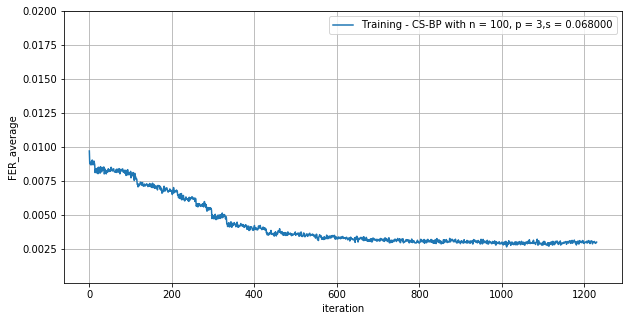

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,generation,generation), accuracies[:generation], '-')
plt.grid(which='both');
plt.xlabel('iteration');
plt.ylabel('FER_average');
plt.ylim([1e-6, 0.02]);
plt.legend(['Training - CS-BP with n = %d, p = %d,s = %f' % (n,P,SPARSITY)]);

In [61]:
pop_w_cv_mat = vector_to_mat(pop_w_cv_vector,pop_w_cv_mat) 
pop_w_vc_mat = vector_to_mat(pop_w_vc_vector,pop_w_vc_mat) 
best_w_cv=pop_w_cv_mat[0]
best_w_vc=pop_w_vc_mat[0]

In [67]:
samples = 100
epochs = 10
ebnos_db = np.linspace(-6,6,24)
fers_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_training[i] += sess.run(fer, feed_dict={
            W_cv:best_w_cv,
            W_vc:best_w_vc,
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_training /= epochs

In [68]:
fers_training

array([0.04458, 0.04169, 0.0383 , 0.03561, 0.03285, 0.02889, 0.02654,
       0.02345, 0.01954, 0.01769, 0.0149 , 0.0129 , 0.01052, 0.00811,
       0.00668, 0.00514, 0.00398, 0.00305, 0.00217, 0.00147, 0.00102,
       0.00049, 0.00051, 0.00036])

In [69]:
fers_no_training = np.zeros(shape=[ebnos_db.shape[0]])

for j in range(epochs):
    for i in range(ebnos_db.shape[0]):
        ebno_db = ebnos_db[i]
        fers_no_training[i] += sess.run(fer, feed_dict={
            batch_size: samples,
            noise_var: ebnodb2noisevar(ebno_db, coderate)
        })
fers_no_training /= epochs

In [70]:
fers_no_training

array([0.05926, 0.05879, 0.05811, 0.05727, 0.05589, 0.05527, 0.05226,
       0.05001, 0.04714, 0.04423, 0.0392 , 0.03505, 0.03062, 0.02497,
       0.02098, 0.01647, 0.01243, 0.00884, 0.00668, 0.00442, 0.00293,
       0.00173, 0.00114, 0.00105])

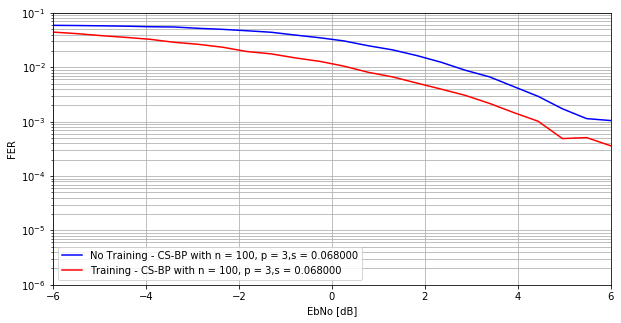

In [71]:
plt.figure(figsize=(10, 5))
plt.semilogy(ebnos_db, fers_no_training, 'b')
plt.semilogy(ebnos_db, fers_training, 'r')
plt.grid(which='both');
plt.xlabel('EbNo [dB]');
plt.ylabel('FER');
plt.ylim([1e-6, 1e-1]);
plt.xlim([ebnos_db[0], ebnos_db[-1]]);
plt.legend(['No Training - CS-BP with n = %d, p = %d,s = %f' % (n,P,SPARSITY),
            'Training - CS-BP with n = %d, p = %d,s = %f' % (n,P,SPARSITY)]);